<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
📦 Import Libraries
</h1>

In [117]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
from bidi.algorithm import get_display
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import datetime
import holidays

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor

import warnings
warnings.filterwarnings('ignore')
import os

In [75]:
df = pd.read_csv('/kaggle/input/padma-bridge-toll-dataset/Padma_Bridge - Traffic.csv',parse_dates=['Date'], dayfirst=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

Now we check for missing values per column

In [76]:
df.head()

Date  Traffic_Mawa  Traffic_Jajira  Cash_Mawa  Cash_Jajira  \
0 2022-01-07         13801           12597   16542100     15111100   
1 2022-01-08          6071            6259    9195100      9670800   
2 2022-01-09          6414            6154    9588950      9781100   
3 2022-01-10          6887            7653   10002700     11063300   
4 2022-01-11          6184            6430    9729450     10116450   

   Total_Traffic Total_Cash  
0          26398   31653200  
1          12330   18865900  
2          12568   19370050  
3          14540   21066000  
4          12614   19845900

In [77]:
print("---- Missing values per column------")
print(df.isnull().sum())

---- Missing values per column------
Date              0
Traffic_Mawa      0
Traffic_Jajira    0
Cash_Mawa         0
Cash_Jajira       0
Total_Traffic     0
Total_Cash        0
dtype: int64


Since there is no missing values, we don't take any other actions. Otherwise, we would have filled out missing values using forward fill method.

In [78]:
df['Total_Cash'].isnull().any()

False

Total cash is an object here. So we convert it into float.

In [79]:
df['Total_Cash'] = (
    df['Total_Cash']
    .astype(str)                
    .str.replace(',', '')      
    .str.strip()                
)

df['Total_Cash'] = pd.to_numeric(df['Total_Cash'], errors='coerce')

In [80]:
df['Total_Cash'] = df['Total_Cash'].fillna(df['Cash_Mawa'] + df['Cash_Jajira'])

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1170 non-null   datetime64[ns]
 1   Traffic_Mawa    1170 non-null   int64         
 2   Traffic_Jajira  1170 non-null   int64         
 3   Cash_Mawa       1170 non-null   int64         
 4   Cash_Jajira     1170 non-null   int64         
 5   Total_Traffic   1170 non-null   int64         
 6   Total_Cash      1170 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 64.1 KB


<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
⚙️ Feature Engineering
</h1>

We mark Friday and Saturday as weekday, and then set offday as True where weekday = 4 or 5. Then we mark Independence day, Martyr day etc as Holidays. This code breaks each date into year, month, and day, and marks weekends. It also adds the weekday number, the day of the year, the week number, and the quarter. Then it checks Bangladesh holidays (plus some extra ones for Quota Movement in 2024) and marks those dates as holidays. To handle repeating cycles like months, days, and weekdays, I used sine and cosine versions so the data understands time is circular.

In [82]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['isWeekend'] =  df['Date'].dt.weekday.isin([4,5]).astype(int)

df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

In [83]:
bd_holidays = holidays.Bangladesh(years=df['Year'].unique())
official_holidays = set(bd_holidays.keys())

extra_holidays = {
    datetime.date(2025, 8, 5),
    datetime.date(2024, 8, 5)
}

all_holidays = official_holidays.union(extra_holidays)

df['isHoliday'] = df['Date'].dt.date.isin(all_holidays).astype(int)

In [84]:
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['Weekend_Holiday'] = df['isWeekend'] * df['isHoliday']
df['Holiday_Month'] = df['isHoliday'] * df['Month']

In [85]:
df.shape

(1170, 24)

In [86]:
df.columns

Index(['Date', 'Traffic_Mawa', 'Traffic_Jajira', 'Cash_Mawa', 'Cash_Jajira',
       'Total_Traffic', 'Total_Cash', 'Year', 'Month', 'Day', 'isWeekend',
       'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter', 'isHoliday',
       'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Weekend_Holiday', 'Holiday_Month'],
      dtype='object')

In [87]:
df.head()

Date  Traffic_Mawa  Traffic_Jajira  Cash_Mawa  Cash_Jajira  \
0 2022-01-07         13801           12597   16542100     15111100   
1 2022-01-08          6071            6259    9195100      9670800   
2 2022-01-09          6414            6154    9588950      9781100   
3 2022-01-10          6887            7653   10002700     11063300   
4 2022-01-11          6184            6430    9729450     10116450   

   Total_Traffic  Total_Cash  Year  Month  Day  ...  Quarter  isHoliday  \
0          26398  31653200.0  2022      1    7  ...        1          0   
1          12330  18865900.0  2022      1    8  ...        1          0   
2          12568  19370050.0  2022      1    9  ...        1          0   
3          14540  21066000.0  2022      1   10  ...        1          0   
4          12614  19845900.0  2022      1   11  ...        1          0   

   Month_sin  Month_cos   Day_sin   Day_cos  DayOfWeek_sin  DayOfWeek_cos  \
0        0.5   0.866025  0.988468  0.151428      -0.433884      -0.900969   
1        0.5   0.866025  0.998717 -0.050649      -0.974928      -0.222521   
2        0.5   0.866025  0.968077 -0.250653      -0.781831       0.623490   
3        0.5   0.866025  0.897805 -0.440394       0.000000       1.000000   
4        0.5   0.866025  0.790776 -0.612106       0.781831       0.623490   

   Weekend_Holiday  Holiday_Month  
0                0              0  
1                0              0  
2                0              0  
3                0              0  
4                0              0  

[5 rows x 24 columns]

<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
📊 Exploratory Data Analysis (EDA)
</h1>

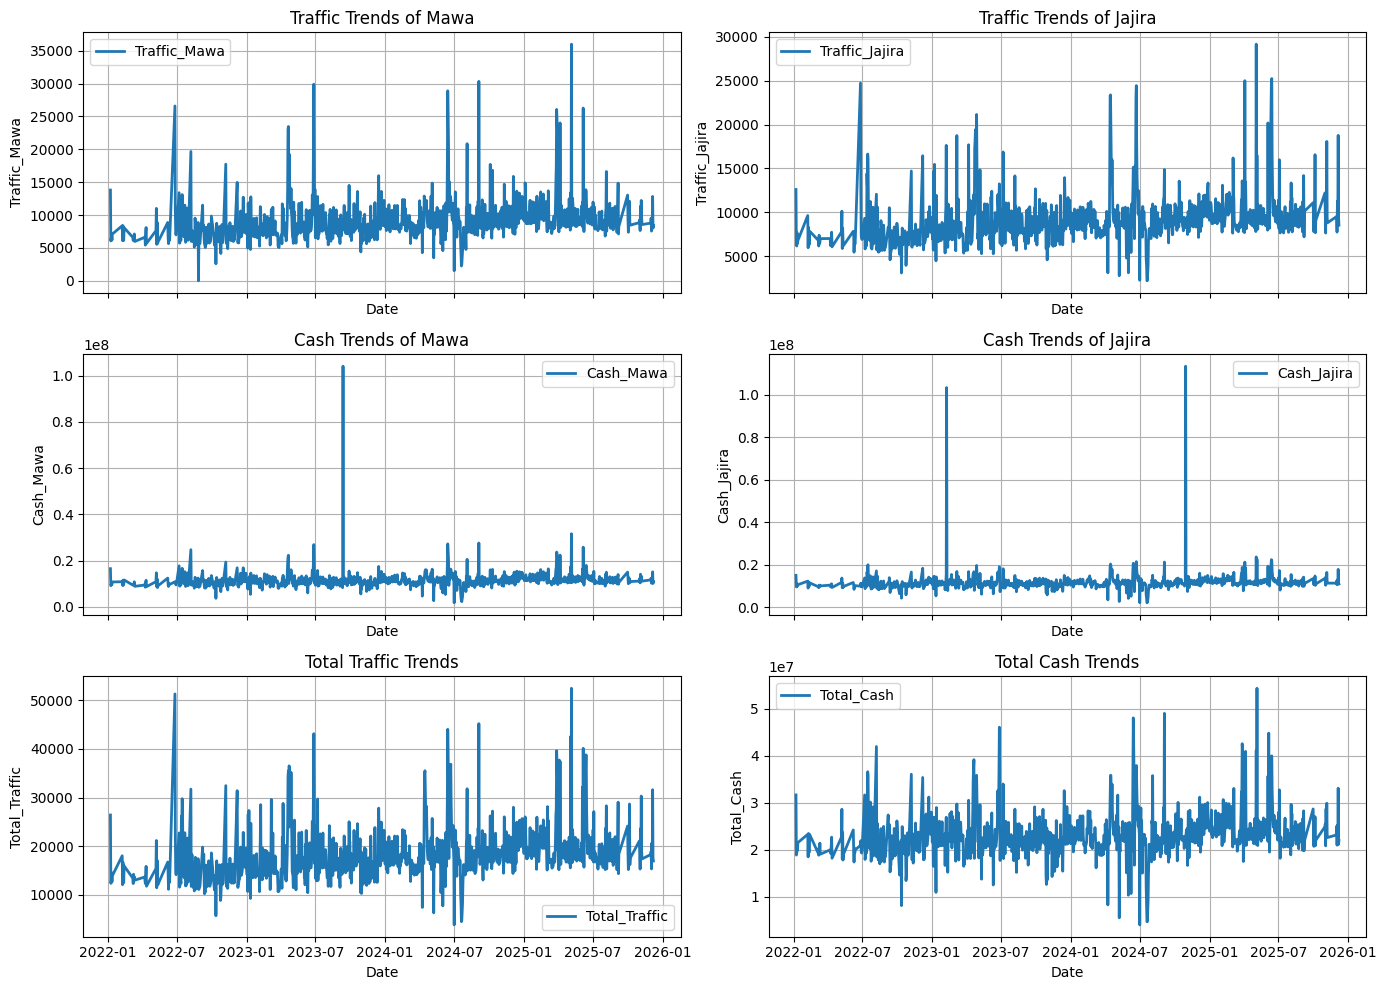

In [88]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(14,10), sharex=True)

axes = axes.flatten()

cols = [
    ('Traffic_Mawa', 'Traffic Trends of Mawa'),
    ('Traffic_Jajira', 'Traffic Trends of Jajira'),
    ('Cash_Mawa', 'Cash Trends of Mawa'),
    ('Cash_Jajira', 'Cash Trends of Jajira'),
    ('Total_Traffic', 'Total Traffic Trends'),
    ('Total_Cash', 'Total Cash Trends')
]

for ax, (col, title) in zip(axes, cols):
    ax.plot(df['Date'], df[col], linewidth=2, label=col)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

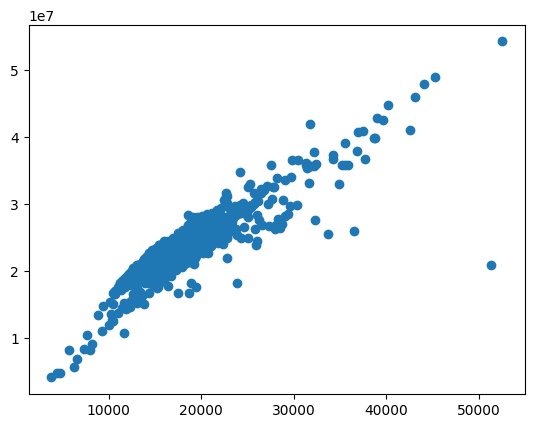

In [89]:
plt.scatter(df['Total_Traffic'], df['Total_Cash'])

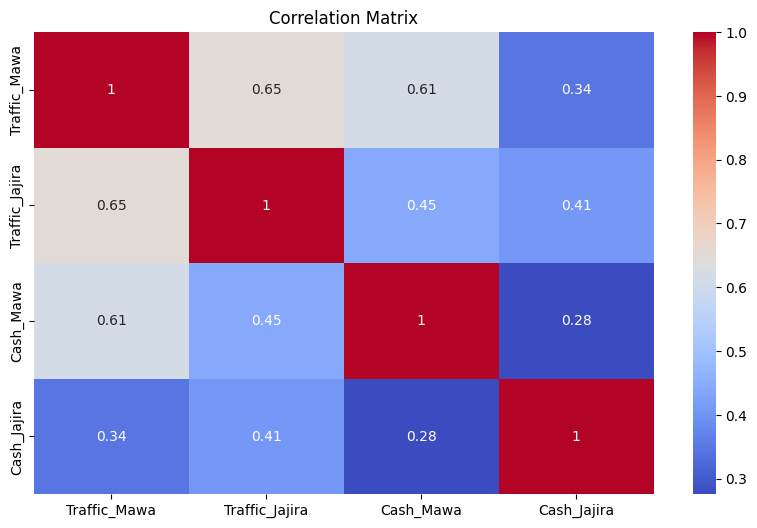

In [90]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['Traffic_Mawa','Traffic_Jajira','Cash_Mawa','Cash_Jajira']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Traffic jajira and taffic mawa has correlation.
Traffic in mawa and cash in mawa has correlation.
However, traffic jajira and cash jajira does not have much correlation.

In [91]:
target_cols = ['Traffic_Mawa','Traffic_Jajira','Cash_Mawa','Cash_Jajira', 'Total_Cash', 'Total_Traffic']

In [92]:
df.describe()

Date  Traffic_Mawa  Traffic_Jajira  \
count                           1170   1170.000000     1170.000000   
mean   2024-01-30 00:29:32.307692288   8825.338462     8940.311966   
min              2022-01-07 00:00:00      6.000000     2188.000000   
25%              2023-04-14 06:00:00   7282.750000     7561.500000   
50%              2024-01-31 12:00:00   8274.000000     8530.000000   
75%              2024-11-18 18:00:00   9645.000000     9924.500000   
max              2025-12-08 00:00:00  35985.000000    29164.000000   
std                              NaN   2961.990979     2648.521343   

          Cash_Mawa   Cash_Jajira  Total_Traffic    Total_Cash         Year  \
count  1.170000e+03  1.170000e+03    1170.000000  1.170000e+03  1170.000000   
mean   1.136663e+07  1.169981e+07   17771.069231  2.281838e+07  2023.578632   
min    1.773650e+06  2.185100e+06    3781.000000  4.019800e+06  2022.000000   
25%    1.010235e+07  1.048510e+07   15008.500000  2.061912e+07  2023.000000   
50%    1.086450e+07  1.126490e+07   16924.500000  2.212432e+07  2024.000000   
75%    1.215046e+07  1.234472e+07   19406.500000  2.440775e+07  2024.000000   
max    1.040765e+08  1.133480e+08   52487.000000  5.432800e+07  2025.000000   
std    3.672648e+06  4.581807e+06    5092.359483  4.533926e+06     0.997544   

             Month          Day  ...      Quarter    isHoliday     Month_sin  \
count  1170.000000  1170.000000  ...  1170.000000  1170.000000  1.170000e+03   
mean      6.535897    15.778632  ...     2.517094     0.020513 -2.371685e-02   
min       1.000000     1.000000  ...     1.000000     0.000000 -1.000000e+00   
25%       4.000000     8.000000  ...     2.000000     0.000000 -8.660254e-01   
50%       7.000000    16.000000  ...     3.000000     0.000000 -2.449294e-16   
75%       9.000000    23.000000  ...     3.000000     0.000000  5.000000e-01   
max      12.000000    31.000000  ...     4.000000     1.000000  1.000000e+00   
std       3.391101     8.786395  ...     1.100648     0.141807  7.041317e-01   

          Month_cos       Day_sin      Day_cos  DayOfWeek_sin  DayOfWeek_cos  \
count  1.170000e+03  1.170000e+03  1170.000000    1170.000000    1170.000000   
mean  -2.984494e-02  9.841275e-03    -0.017907       0.002294       0.000711   
min   -1.000000e+00 -9.987165e-01    -0.994869      -0.974928      -0.900969   
25%   -8.660254e-01 -7.247928e-01    -0.758758      -0.781831      -0.900969   
50%   -1.836970e-16 -2.449294e-16    -0.050649       0.000000      -0.222521   
75%    5.000000e-01  7.247928e-01     0.688967       0.781831       0.623490   
max    1.000000e+00  9.987165e-01     1.000000       0.974928       1.000000   
std    7.096475e-01  7.198713e-01     0.694423       0.707769       0.707045   

       Weekend_Holiday  Holiday_Month  
count      1170.000000    1170.000000  
mean          0.005128       0.115385  
min           0.000000       0.000000  
25%           0.000000       0.000000  
50%           0.000000       0.000000  
75%           0.000000       0.000000  
max           1.000000      12.000000  
std           0.071458       0.919991  

[8 rows x 24 columns]

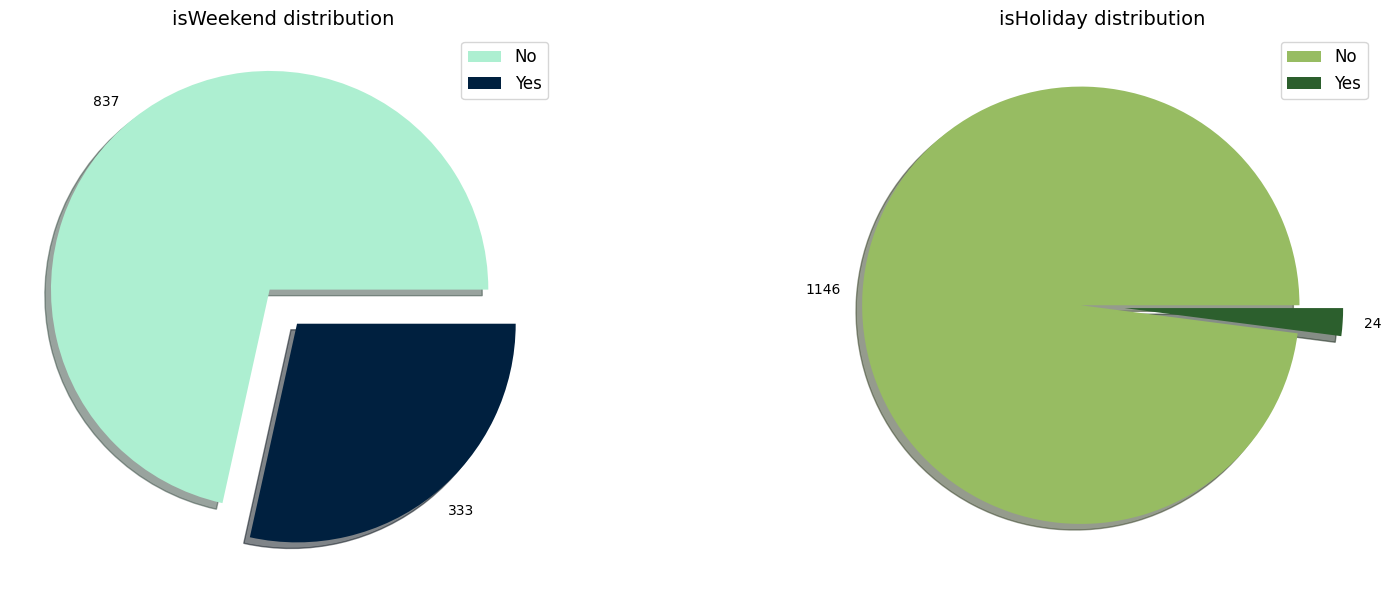

In [93]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))

colors_list = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D']]
columns = ['isWeekend', 'isHoliday']

for i in range(2):
    data = df[columns[i]].value_counts() 
    explode = [0.1]*len(data)            
    colors = colors_list[i][:len(data)] 
    ax[i].pie(
        data.values,
        labels=data.values,
        explode=explode,
        colors=colors,
        shadow=True,
    )
    ax[i].set_title(f'{columns[i]} distribution', fontsize=14)
    ax[i].legend(labels=['No', 'Yes'], fontsize=12)

plt.tight_layout()
plt.show()

In [94]:
pd.crosstab(df.isHoliday, df.Year)

Year       2022  2023  2024  2025
isHoliday                        
0           187   358   358   243
1             2     7     8     7

In [95]:
pd.crosstab(df.isHoliday, df.Month)

Month      1   2   3   4   5   6    7    8   9   10  11  12
isHoliday                                                  
0          96  85  90  90  93  98  115  108  92  95  92  92
1           0   3   6   3   3   0    0    6   0   0   0   3

<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
🧪 Model Training
</h1>

In [96]:
target_cols = ['Traffic_Mawa','Traffic_Jajira','Cash_Mawa','Cash_Jajira', 'Total_Cash', 'Total_Traffic']

This portion of the code looks at each target_cols and creates new columns that contains values from:

- 1 day ago
- 7 days ago
- 14 days ago
- 30 days ago

This helps our model to see past values easily. Example: our model can now "remember" what happened last day, last week, two weeks ago and last month.

In [97]:
lags=[1, 7, 14, 30]
    
for col in target_cols:
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

For each column, it looks at the past 7, 14, and 30 days and calculates:

- **Rolling mean:** average of the past days

- **Rolling standard deviation:** how much the past values vary

- **Rolling min/max:** lowest and highest values in the past days

- **Exponential weighted mean:** like an average that gives more weight to recent days

In [98]:
windows=[7, 14, 30]

for col in target_cols:
    for window in windows:
        df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
        df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()
        df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window).min()
        df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window).max()
        
        # Exponential weighted mean
        df[f'{col}_ewm_mean_{window}'] = df[col].ewm(span=window).mean()

In [101]:
print(f"Features created. Shape before dropping NaN: {df.shape}")

df = df.dropna()

print(f"Shape after dropping NaN: {df.shape}")

Features created. Shape before dropping NaN: (1170, 138)
Shape after dropping NaN: (1140, 138)


In [103]:
exclude_cols = target_cols + ['Date']
feature_cols = [col for col in df.columns if col not in exclude_cols]

In [105]:
X = df[feature_cols]
y = df[target_cols]

print(f"Final feature set: {len(feature_cols)} features")

Final feature set: 131 features


In [109]:
print("All feature names:")
print(feature_cols)

All feature names:
['Year', 'Month', 'Day', 'isWeekend', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter', 'isHoliday', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Weekend_Holiday', 'Holiday_Month', 'Traffic_Mawa_lag_1', 'Traffic_Mawa_lag_7', 'Traffic_Mawa_lag_14', 'Traffic_Mawa_lag_30', 'Traffic_Jajira_lag_1', 'Traffic_Jajira_lag_7', 'Traffic_Jajira_lag_14', 'Traffic_Jajira_lag_30', 'Cash_Mawa_lag_1', 'Cash_Mawa_lag_7', 'Cash_Mawa_lag_14', 'Cash_Mawa_lag_30', 'Cash_Jajira_lag_1', 'Cash_Jajira_lag_7', 'Cash_Jajira_lag_14', 'Cash_Jajira_lag_30', 'Total_Cash_lag_1', 'Total_Cash_lag_7', 'Total_Cash_lag_14', 'Total_Cash_lag_30', 'Total_Traffic_lag_1', 'Total_Traffic_lag_7', 'Total_Traffic_lag_14', 'Total_Traffic_lag_30', 'Traffic_Mawa_rolling_mean_7', 'Traffic_Mawa_rolling_std_7', 'Traffic_Mawa_rolling_min_7', 'Traffic_Mawa_rolling_max_7', 'Traffic_Mawa_ewm_mean_7', 'Traffic_Mawa_rolling_mean_14', 'Traffic_Mawa_rolling_std_14', 'Traffic_Mawa_rolling_

`TimeSeriesSplit(n_splits=5)` splits our data into 5 sequential folds without shuffling, which is important for time-dependent data. `list(tsa_main.split(X))[-1]` takes the last split, giving the most recent chunk of data as the test set. `train_idx` and `test_idx` are the row indices for the training and test sets.

In [113]:
tsa_main = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tsa_main.split(X))[-1] 

In [114]:
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Training date range: {df.iloc[train_idx]['Date'].min()} to {df.iloc[train_idx]['Date'].max()}")
print(f"Test date range: {df.iloc[test_idx]['Date'].min()} to {df.iloc[test_idx]['Date'].max()}")


Training set: 950 samples
Test set: 190 samples
Training date range: 2022-06-07 00:00:00 to 2025-03-07 00:00:00
Test date range: 2025-03-08 00:00:00 to 2025-12-08 00:00:00


Now, we standardize the data so each feature has mean 0 and standard deviation 1. We are using MultipleOutputRegressor because this model allows the random forest to **predict multiple target columns at once.**

In [115]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [118]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
multi_rf = MultiOutputRegressor(rf)

In [119]:
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['sqrt', 'log2', None]
}

tsa = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    multi_rf, 
    param_grid, 
    cv=tsa, 
    scoring='neg_mean_absolute_error', 
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

In [120]:
print("===== Training RF model with hyperparameter tuning=====")
grid.fit(X_train_scaled, y_train)
best_multi_model = grid.best_estimator_

===== Training RF model with hyperparameter tuning=====
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   2.5s
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   3.8s
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200; total time=   7.7s
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=300; total time=  11.6s
[CV] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=200; total time=   5.7s
[CV] 

In [125]:
print("\nBest Parameters:")
for param, value in grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score (Negative MAE): {grid.best_score_:.4f}")


Best Parameters:
  estimator__max_depth: 10
  estimator__max_features: None
  estimator__min_samples_leaf: 4
  estimator__min_samples_split: 2
  estimator__n_estimators: 300

Best CV Score (Negative MAE): -729133.7008


<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
📈 Making Predictions
</h1>

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


print("\nMaking predictions...")
y_pred = best_multi_model.predict(X_test_scaled)
preds_df = pd.DataFrame(y_pred, columns=target_cols, index=X_test.index)

metrics_dict = {}
for i, col in enumerate(target_cols):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]
    
    mse = mean_squared_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred_col)
    r2 = r2_score(y_true, y_pred_col)
    
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred_col[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    metrics_dict[col] = {
        'MSE': mse, 
        'RMSE': rmse, 
        'MAE': mae, 
        'MAPE (%)': mape, 
        'R2': r2
    }

metrics_df = pd.DataFrame(metrics_dict).T
print("\nModel Performance Metrics:")
print(metrics_df.round(4))


Making predictions...

Model Performance Metrics:
                         MSE          RMSE           MAE  MAPE (%)      R2
Traffic_Mawa    5.557513e+06  2.357438e+03  1.268607e+03   11.2790  0.5590
Traffic_Jajira  5.545436e+06  2.354875e+03  1.268092e+03   11.2681  0.4283
Cash_Mawa       3.305410e+12  1.818079e+06  1.037359e+06    7.7072  0.5837
Cash_Jajira     2.876335e+12  1.695976e+06  1.022642e+06    7.9034  0.5170
Total_Cash      9.638497e+12  3.104593e+06  1.849335e+06    7.0066  0.6198
Total_Traffic   1.602659e+07  4.003322e+03  2.306417e+03   10.1472  0.5109


This code tells us which features the model thinks are most important for predicting each target to understand what drives the model predictions.

In [126]:
feature_importance = {}
for i, col in enumerate(target_cols):
    importance = best_multi_model.estimators_[i].feature_importances_
    feature_importance[col] = dict(zip(feature_cols, importance))

In [127]:
print("\nTop 15 Most Important Features:")
for col in target_cols:
    print(f"\n{col}:")
    sorted_features = sorted(feature_importance[col].items(), 
                           key=lambda x: x[1], reverse=True)
    for feature, importance in sorted_features[:15]:
        print(f"  {feature}: {importance:.4f}")


Top 15 Most Important Features:

Traffic_Mawa:
  Traffic_Mawa_ewm_mean_7: 0.5612
  Cash_Mawa_ewm_mean_7: 0.0591
  DayOfWeek_cos: 0.0283
  Total_Traffic_lag_7: 0.0267
  Traffic_Jajira_lag_1: 0.0176
  Traffic_Mawa_lag_7: 0.0169
  Traffic_Jajira_rolling_mean_14: 0.0153
  Traffic_Mawa_rolling_std_7: 0.0137
  Traffic_Jajira_rolling_mean_30: 0.0100
  Total_Traffic_ewm_mean_7: 0.0097
  Total_Cash_ewm_mean_7: 0.0096
  Cash_Jajira_ewm_mean_7: 0.0096
  Traffic_Mawa_lag_1: 0.0086
  Traffic_Mawa_rolling_mean_7: 0.0075
  Traffic_Mawa_rolling_min_7: 0.0071

Traffic_Jajira:
  Traffic_Jajira_ewm_mean_7: 0.3169
  Total_Traffic_ewm_mean_7: 0.2597
  Traffic_Mawa_ewm_mean_7: 0.0466
  Traffic_Jajira_rolling_std_7: 0.0324
  Traffic_Jajira_lag_1: 0.0178
  Cash_Jajira_rolling_min_7: 0.0168
  isWeekend: 0.0145
  Total_Traffic_rolling_std_14: 0.0121
  Traffic_Jajira_rolling_max_7: 0.0117
  Cash_Jajira_ewm_mean_7: 0.0111
  Total_Cash_rolling_min_7: 0.0106
  Traffic_Mawa_lag_1: 0.0105
  Total_Traffic_rolling_mea

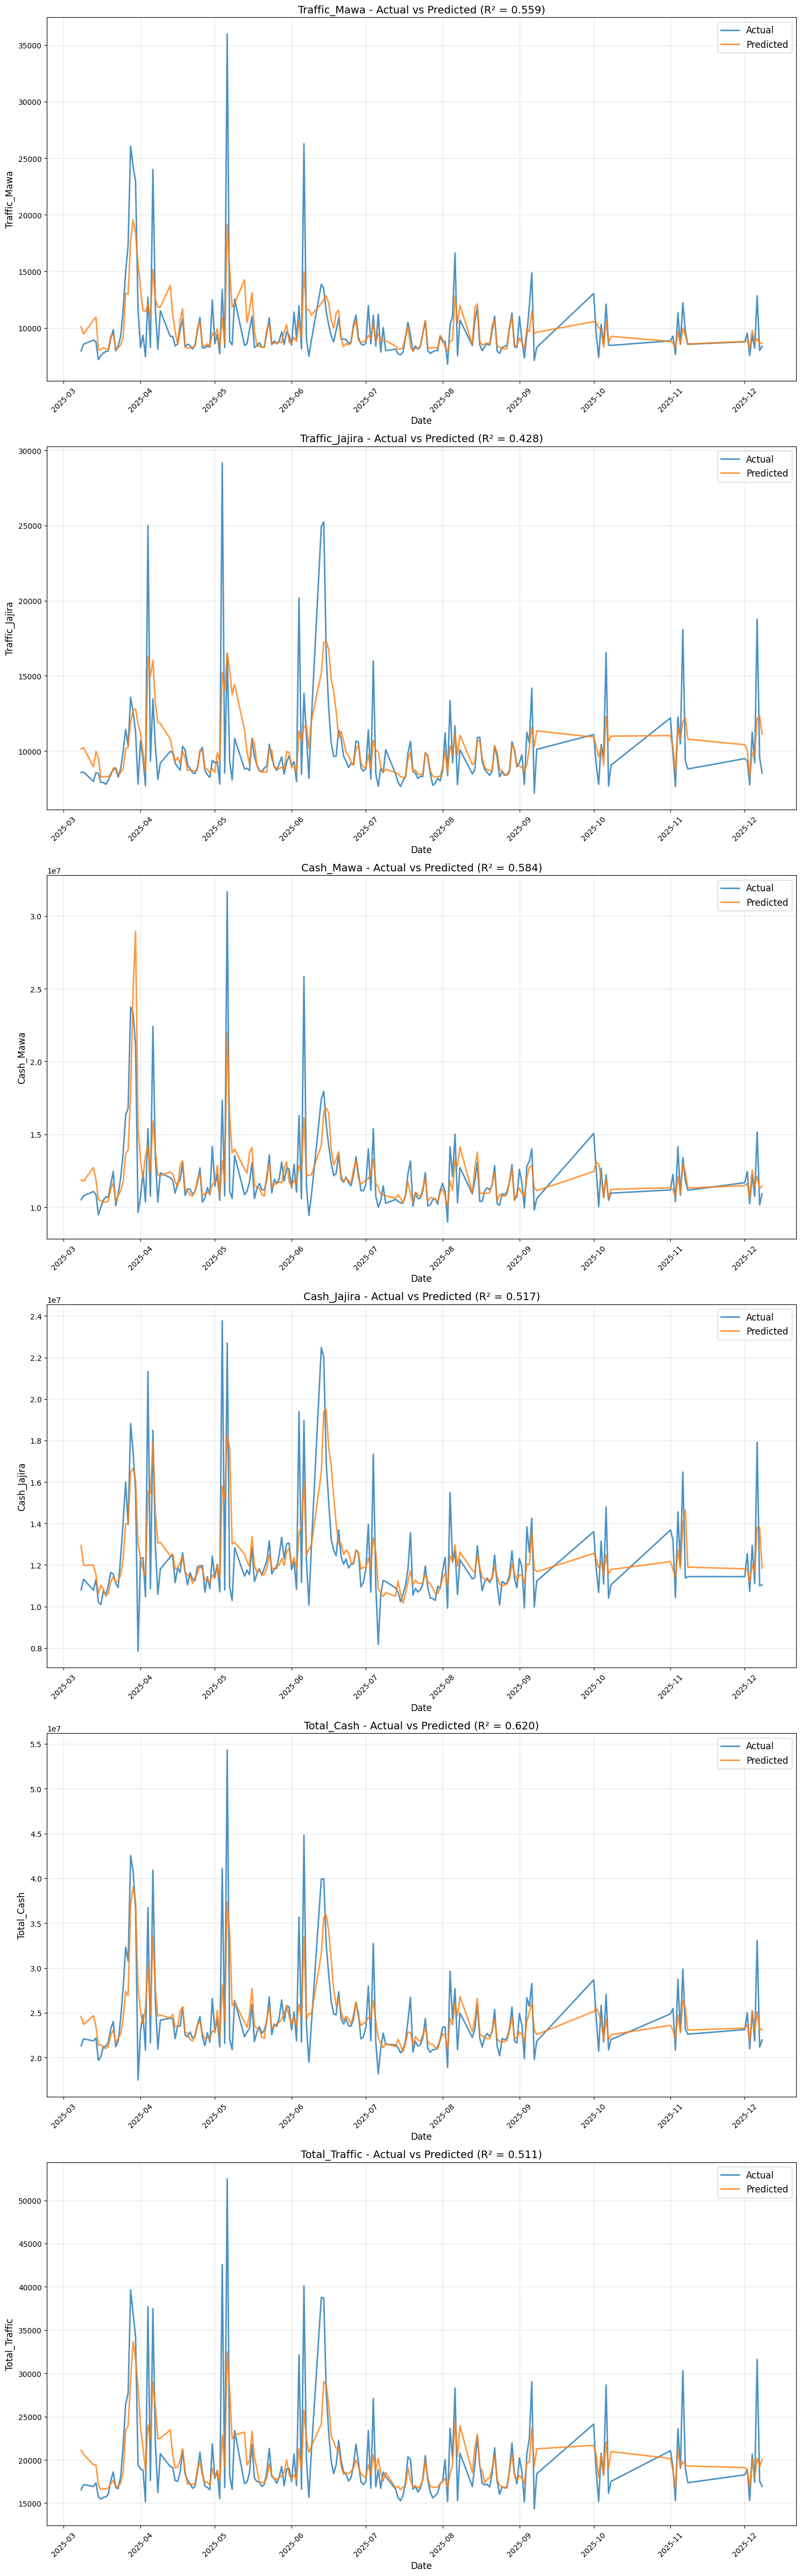

In [129]:
fig, axes = plt.subplots(len(target_cols), 1, figsize=(15, 8*len(target_cols)))
if len(target_cols) == 1:
    axes = [axes]

for i, col in enumerate(target_cols):
    test_dates = df.iloc[test_idx]['Date'].values
    
    axes[i].plot(test_dates, y_test[col].values, label='Actual', alpha=0.8, linewidth=2)
    axes[i].plot(test_dates, y_pred[:, i], label='Predicted', alpha=0.8, linewidth=2)
    axes[i].set_title(f'{col} - Actual vs Predicted (R² = {metrics_dict[col]["R2"]:.3f})', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)
    axes[i].legend(fontsize=12)
    axes[i].grid(True, alpha=0.3)

    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [130]:
print("\nResidual Analysis:")
for i, col in enumerate(target_cols):
    residuals = y_test[col].values - y_pred[:, i]
    print(f"\n{col}:")
    print(f"  Mean Residual: {np.mean(residuals):.4f}")
    print(f"  Std Residual: {np.std(residuals):.4f}")
    print(f"  Min Residual: {np.min(residuals):.4f}")
    print(f"  Max Residual: {np.max(residuals):.4f}")
    
    # Residual normality should be close to 0
    print(f"  Residual Mean/Std Ratio: {np.mean(residuals)/np.std(residuals):.4f}")


Residual Analysis:

Traffic_Mawa:
  Mean Residual: 24.5991
  Std Residual: 2357.3094
  Min Residual: -6390.1138
  Max Residual: 16821.1447
  Residual Mean/Std Ratio: 0.0104

Traffic_Jajira:
  Mean Residual: -159.3934
  Std Residual: 2349.4743
  Min Residual: -6120.3319
  Max Residual: 13937.5881
  Residual Mean/Std Ratio: -0.0678

Cash_Mawa:
  Mean Residual: -5818.3280
  Std Residual: 1818069.2130
  Min Residual: -7778505.1384
  Max Residual: 9705130.6543
  Residual Mean/Std Ratio: -0.0032

Cash_Jajira:
  Mean Residual: -52999.1101
  Std Residual: 1695147.8352
  Min Residual: -6698166.1899
  Max Residual: 7974557.2562
  Residual Mean/Std Ratio: -0.0313

Total_Cash:
  Mean Residual: 101705.4774
  Std Residual: 3102926.4489
  Min Residual: -11936193.0149
  Max Residual: 16957419.1987
  Residual Mean/Std Ratio: 0.0328

Total_Traffic:
  Mean Residual: 163.0429
  Std Residual: 4000.0004
  Min Residual: -9926.2953
  Max Residual: 20003.0431
  Residual Mean/Std Ratio: 0.0408


<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
🔮 Forecasting
</h1>

In [172]:
N_DAYS = 365

In [173]:
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=N_DAYS)
future_df = pd.DataFrame({'Date': future_dates})

In [174]:
def create_time_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['isWeekend'] = df['Date'].dt.weekday.isin([4,5]).astype(int)

    bd_holidays = holidays.Bangladesh(years=df['Year'].unique())
    official_holidays = set(bd_holidays.keys())
    
    extra_holidays = {
        datetime.date(2025, 8, 5),
        datetime.date(2024, 8, 5)
    }
    
    all_holidays = official_holidays.union(extra_holidays)
    
    df['isHoliday'] = df['Date'].dt.date.isin(all_holidays).astype(int)
    df['Weekend_Holiday'] = df['isWeekend'] * df['isHoliday']
    df['Holiday_Month'] = df['isHoliday'] * df['Month']
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    
    return df

future_df = create_time_features(future_df)

In [175]:
lags = [1, 7, 14, 30]
windows = [7, 14, 30]

last_known = df.copy()  
predictions = []

for i in range(N_DAYS):
    new_row = future_df.iloc[i:i+1].copy()
    
    for col in target_cols:
        for lag in lags:
            new_row[f'{col}_lag_{lag}'] = last_known[col].iloc[-lag]
    
    for col in target_cols:
        for window in windows:
            series = last_known[col].iloc[-window:]
            new_row[f'{col}_rolling_mean_{window}'] = series.mean()
            new_row[f'{col}_rolling_std_{window}'] = series.std()
            new_row[f'{col}_rolling_min_{window}'] = series.min()
            new_row[f'{col}_rolling_max_{window}'] = series.max()
            new_row[f'{col}_ewm_mean_{window}'] = series.ewm(span=window).mean().iloc[-1]

    X_future = new_row[feature_cols]
    X_future_scaled = scaler.transform(X_future)
   
    pred = best_multi_model.predict(X_future_scaled)
    predictions.append(pred[0])
    
    new_pred_df = pd.DataFrame(pred, columns=target_cols)
    last_known = pd.concat([last_known, new_pred_df], ignore_index=True)

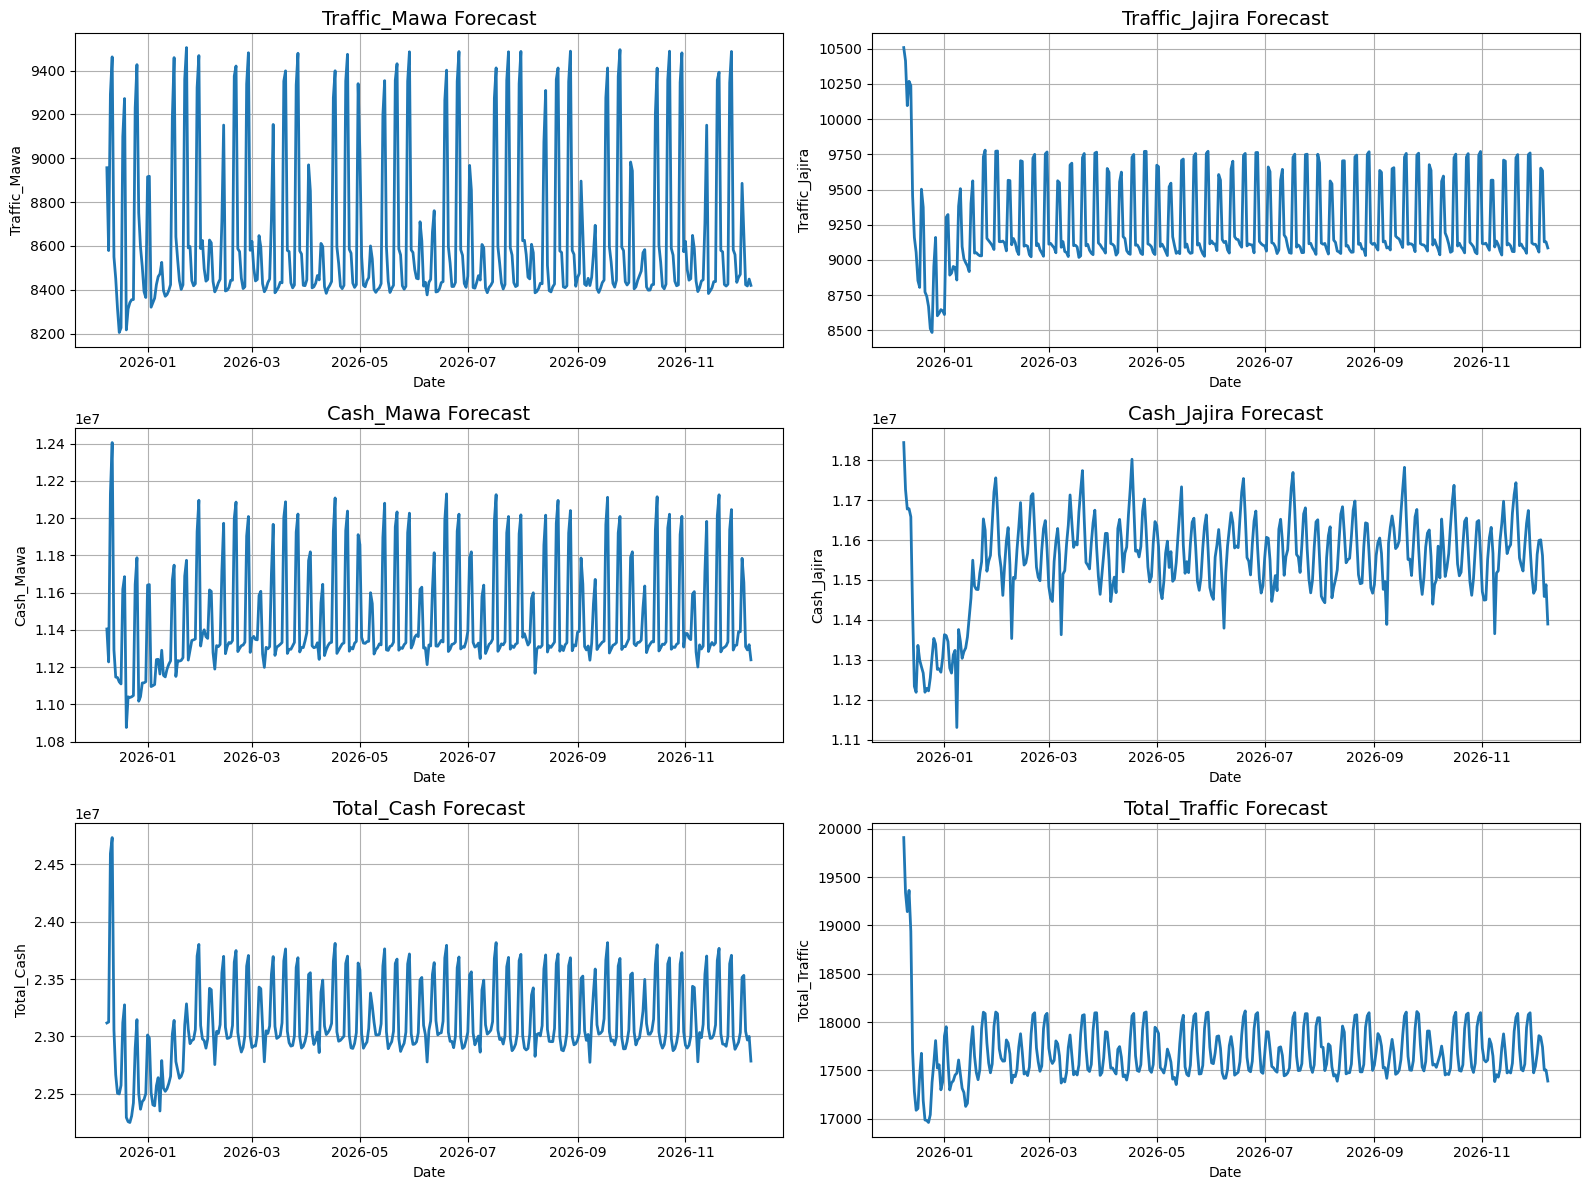

In [176]:
import pandas as pd
import matplotlib.pyplot as plt

future_pred_df = pd.DataFrame(predictions, columns=target_cols, index=future_df['Date'])

n_targets = len(target_cols)
n_cols = 2
n_rows = (n_targets + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    axes[i].plot(future_pred_df.index, future_pred_df[col], color='tab:blue', linewidth=2)
    axes[i].set_title(f'{col} Forecast', fontsize=14)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].grid(True)

# hide unused subplots if any
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [177]:
print("\n" + "="*60)
print("FORECAST SUMMARY")
print("="*60)
print(f"Forecast period: {future_dates[0].date()} to {future_dates[-1].date()}")
print(f"Number of days forecasted: {N_DAYS}")

for col in target_cols:
    forecast_data = future_pred_df[col]
    print(f"\n{col} Forecast Statistics:")
    print(f"  Mean: {forecast_data.mean():.2f}")
    print(f"  Std:  {forecast_data.std():.2f}")
    print(f"  Min:  {forecast_data.min():.2f}")
    print(f"  Max:  {forecast_data.max():.2f}")
    print(f"  Median: {forecast_data.median():.2f}")

future_pred_df_with_features = future_pred_df.copy()
future_pred_df_with_features['Month'] = future_pred_df_with_features.index.month
future_pred_df_with_features['DayOfWeek'] = future_pred_df_with_features.index.dayofweek
future_pred_df_with_features['IsWeekend'] = future_pred_df_with_features['DayOfWeek'].isin([5, 6])

print(f"\nWeekend vs Weekday Average:")
for col in target_cols:
    weekend_avg = future_pred_df_with_features[future_pred_df_with_features['IsWeekend']][col].mean()
    weekday_avg = future_pred_df_with_features[~future_pred_df_with_features['IsWeekend']][col].mean()
    print(f"  {col}: Weekend = {weekend_avg:.2f}, Weekday = {weekday_avg:.2f}")

future_pred_df.to_csv('padma_bridge_forecast.csv')
print(f"\nForecasting completed successfully!")


FORECAST SUMMARY
Forecast period: 2025-12-09 to 2026-12-08
Number of days forecasted: 365

Traffic_Mawa Forecast Statistics:
  Mean: 8641.36
  Std:  353.90
  Min:  8204.78
  Max:  9504.58
  Median: 8452.12

Traffic_Jajira Forecast Statistics:
  Mean: 9249.00
  Std:  314.41
  Min:  8484.67
  Max:  10507.84
  Median: 9111.13

Cash_Mawa Forecast Statistics:
  Mean: 11450573.89
  Std:  278582.69
  Min:  10875827.07
  Max:  12405636.39
  Median: 11324775.63

Cash_Jajira Forecast Statistics:
  Mean: 11551344.79
  Std:  112623.82
  Min:  11130660.63
  Max:  11844061.33
  Median: 11565994.77

Total_Cash Forecast Statistics:
  Mean: 23112209.98
  Std:  350064.43
  Min:  22249180.18
  Max:  24733678.05
  Median: 23022049.71

Total_Traffic Forecast Statistics:
  Mean: 17688.98
  Std:  311.94
  Min:  16959.21
  Max:  19910.91
  Median: 17609.10

Weekend vs Weekday Average:
  Traffic_Mawa: Weekend = 8494.99, Weekday = 8699.68
  Traffic_Jajira: Weekend = 9390.05, Weekday = 9192.79
  Cash_Mawa: Week

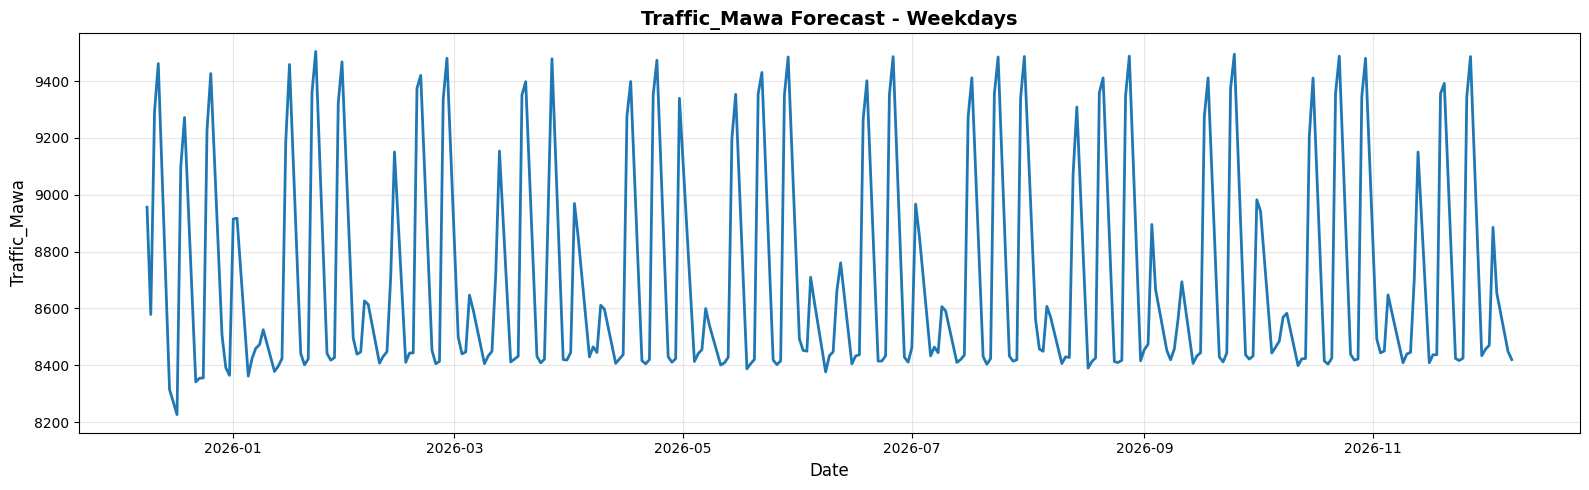

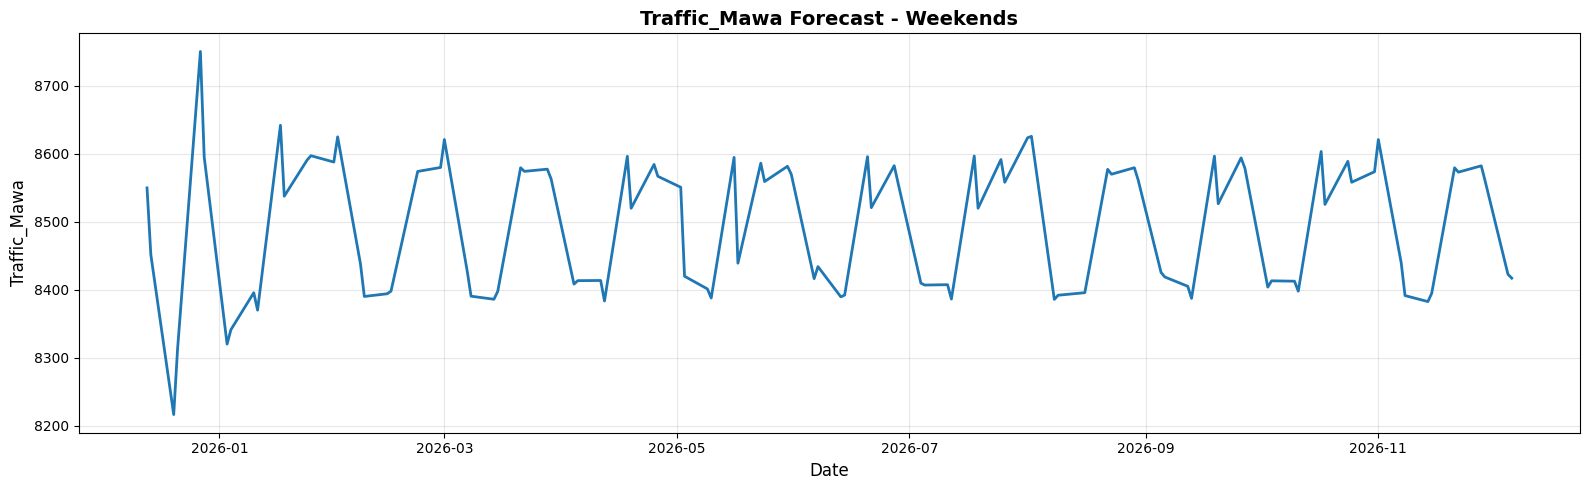

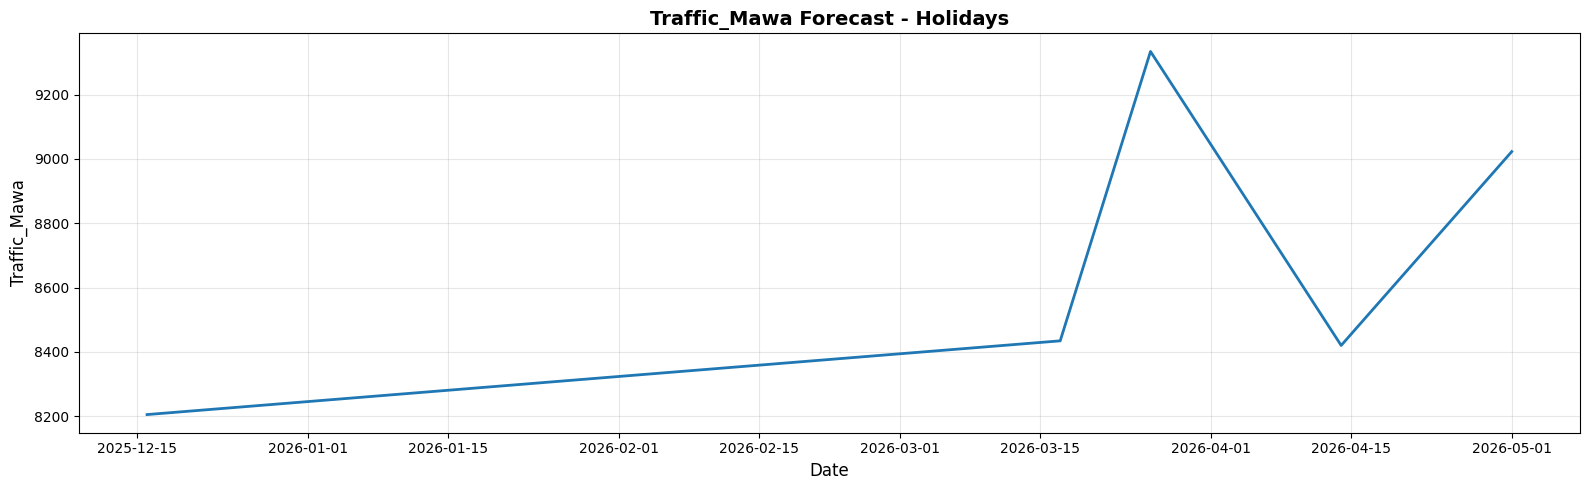

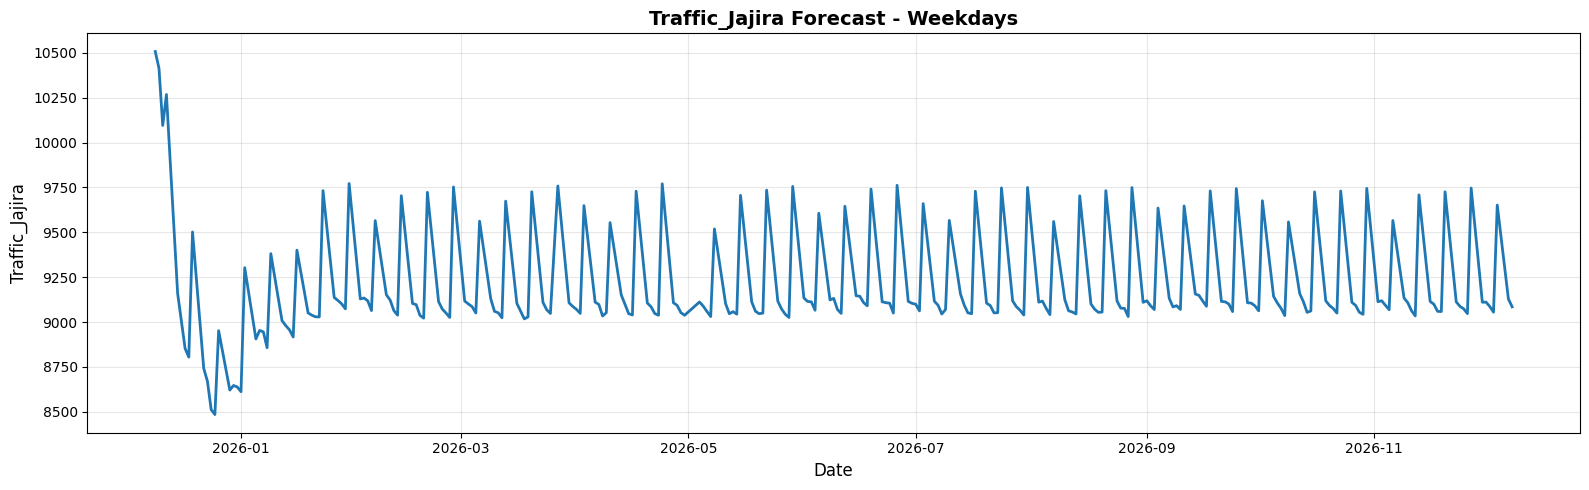

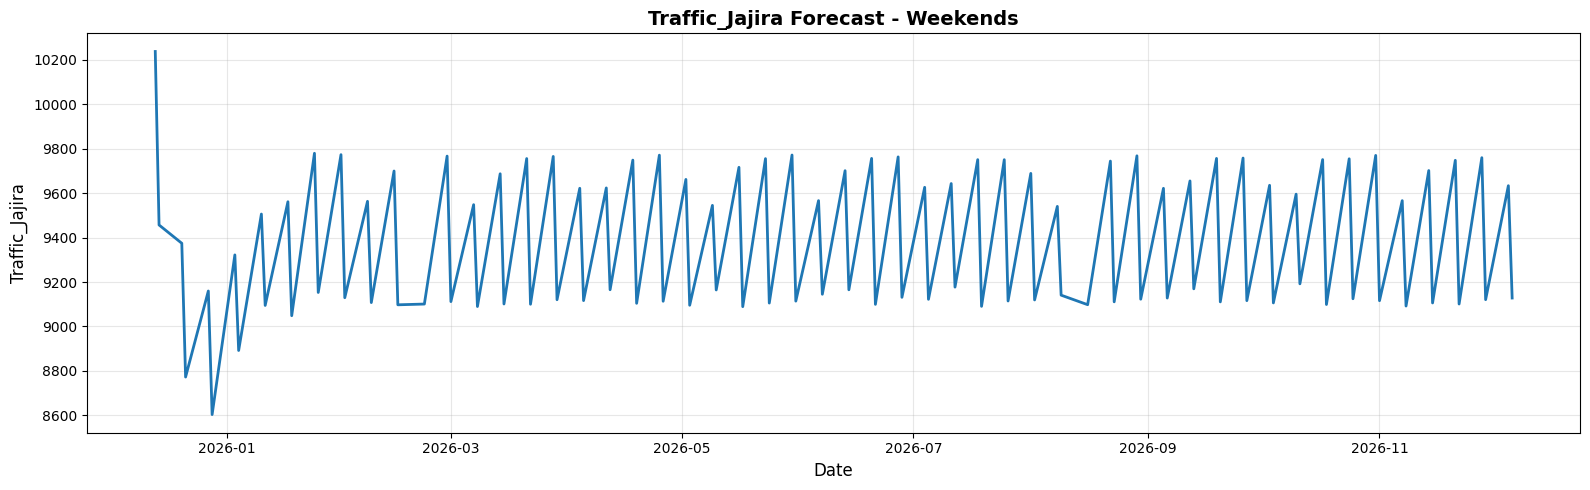

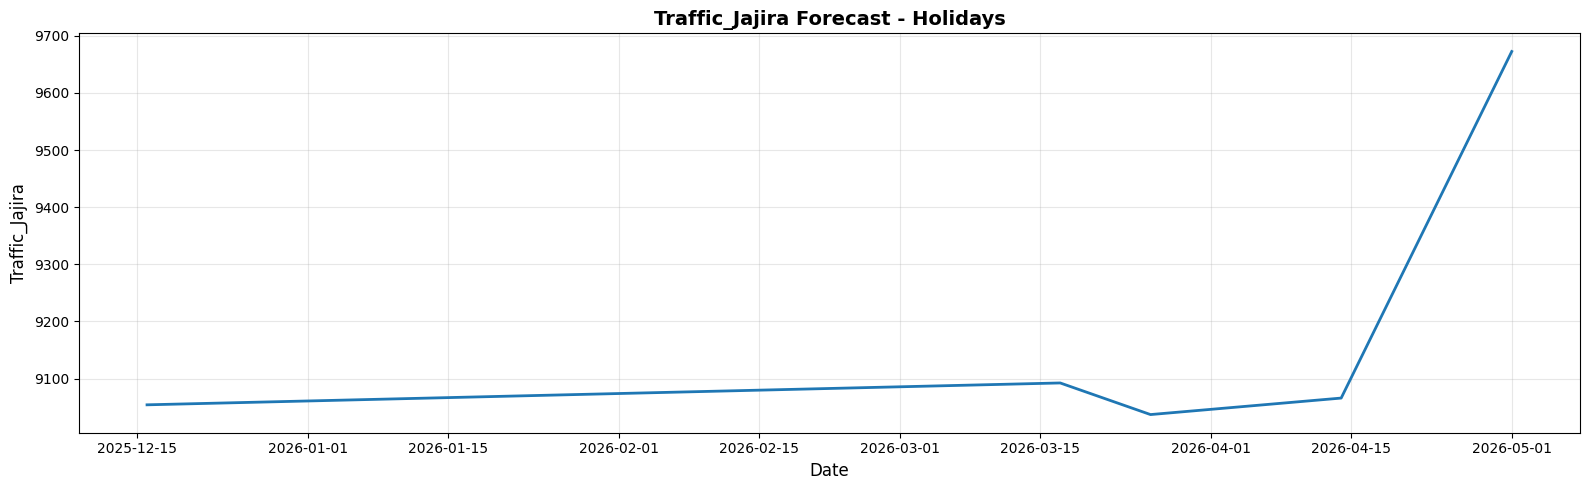

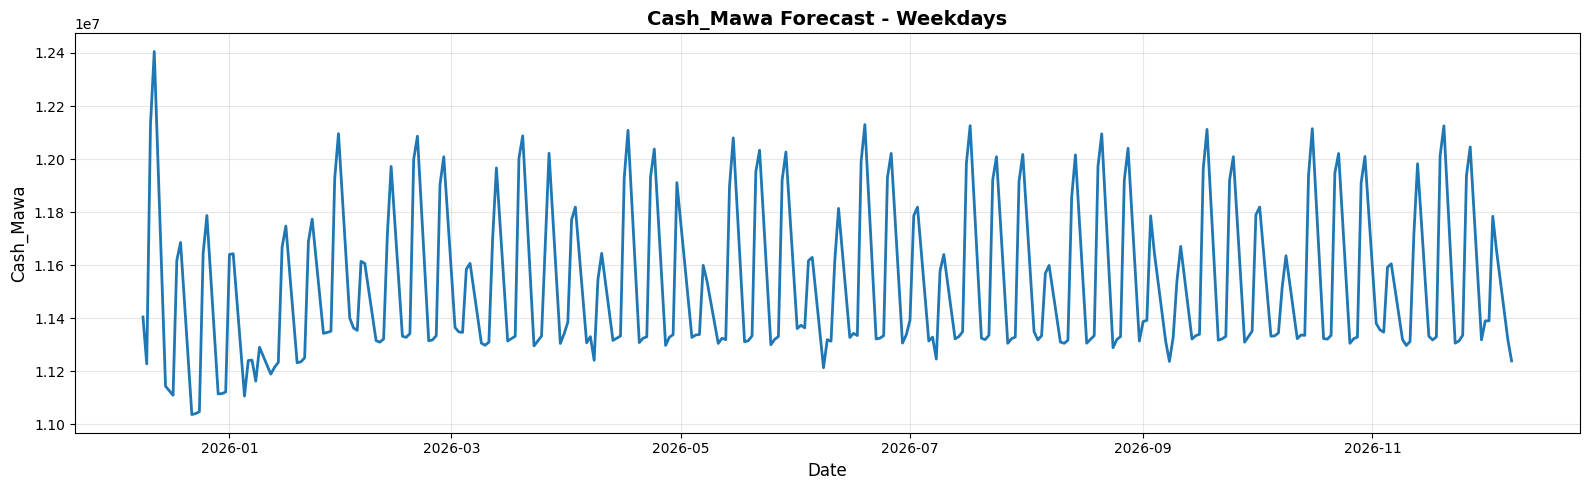

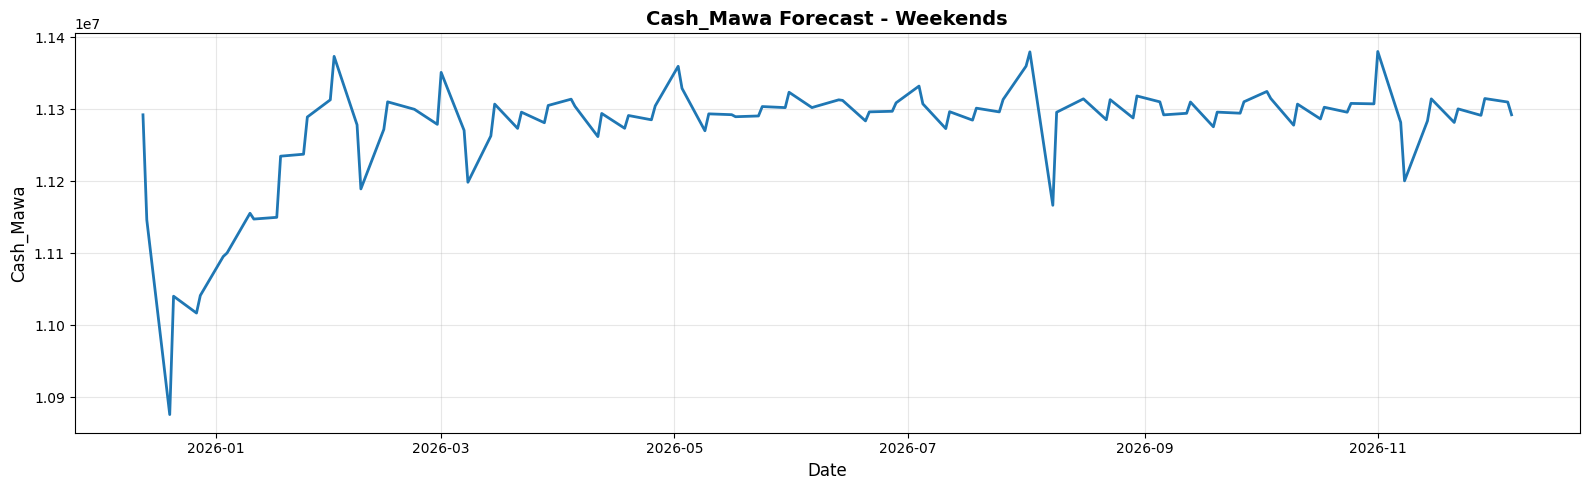

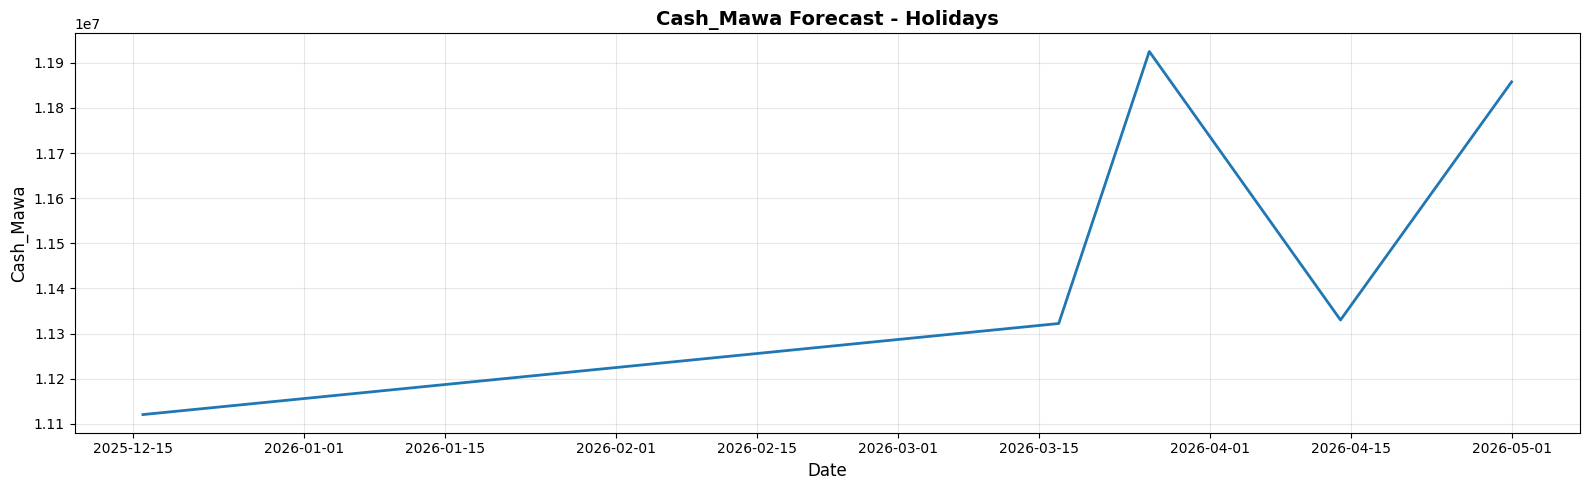

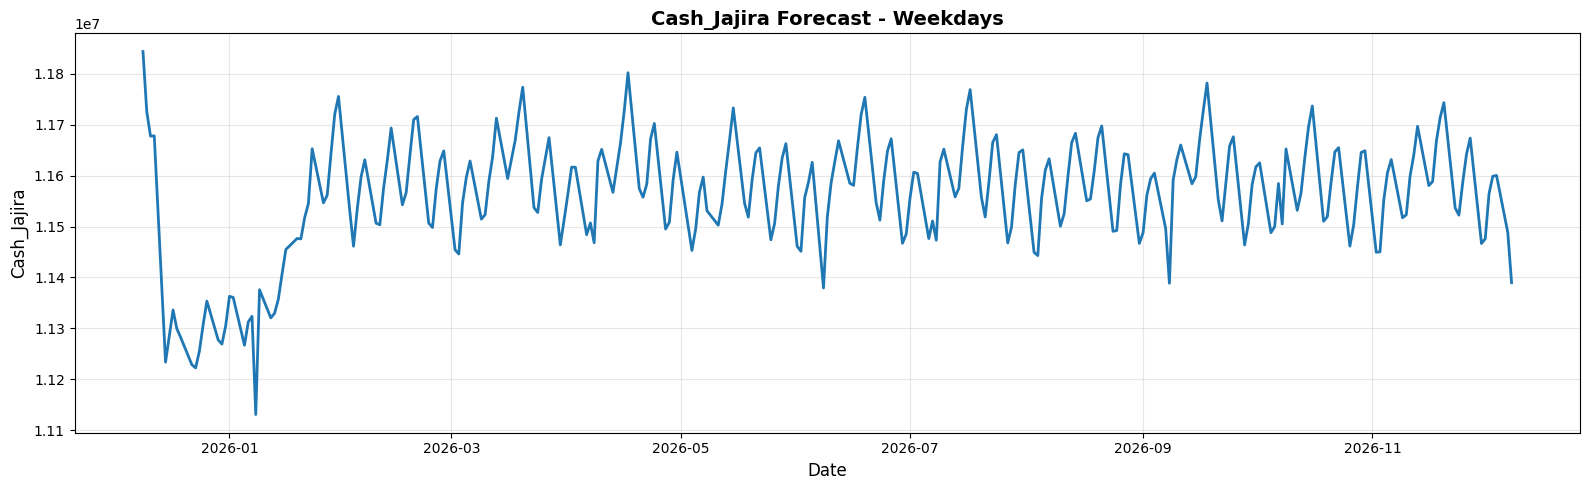

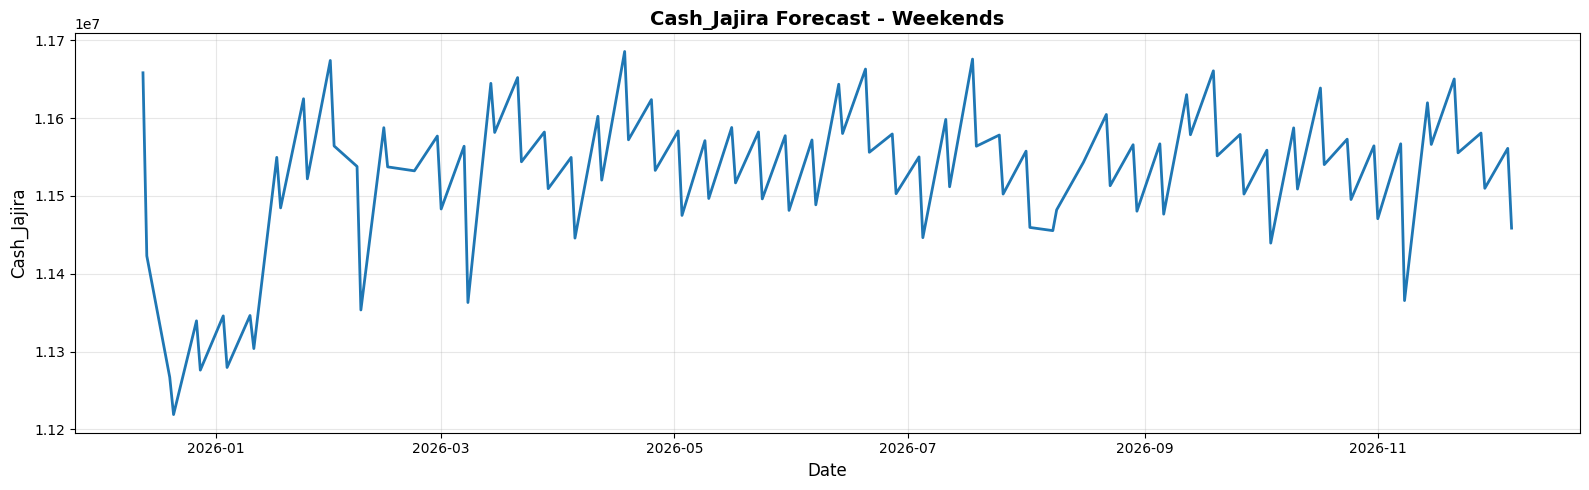

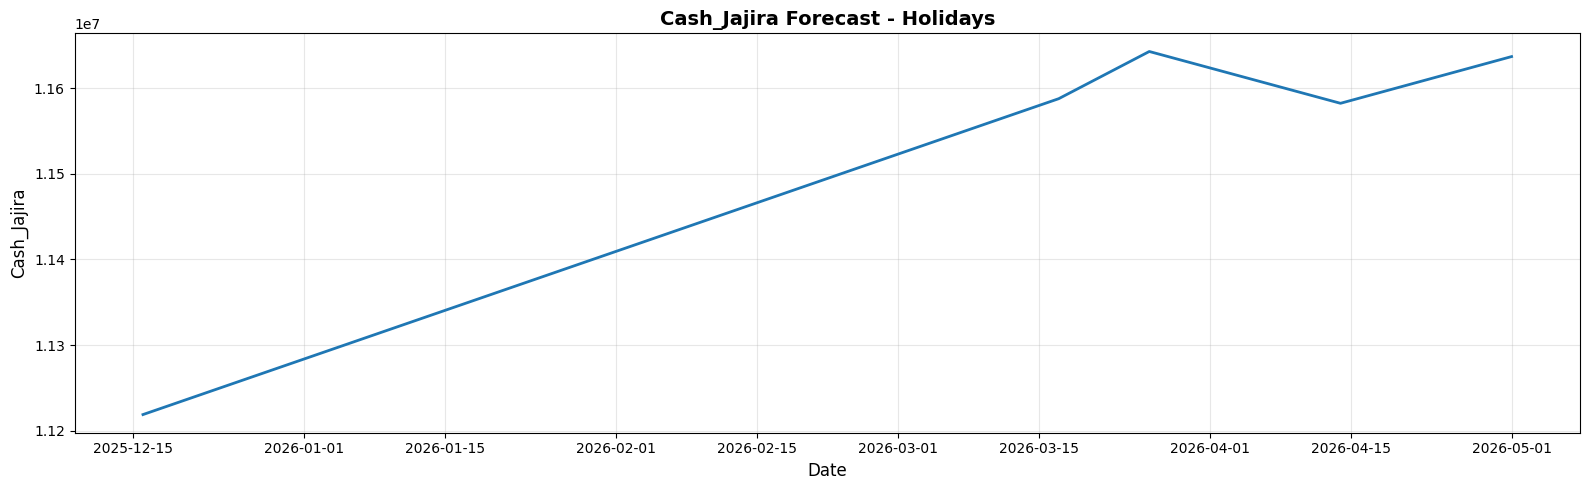

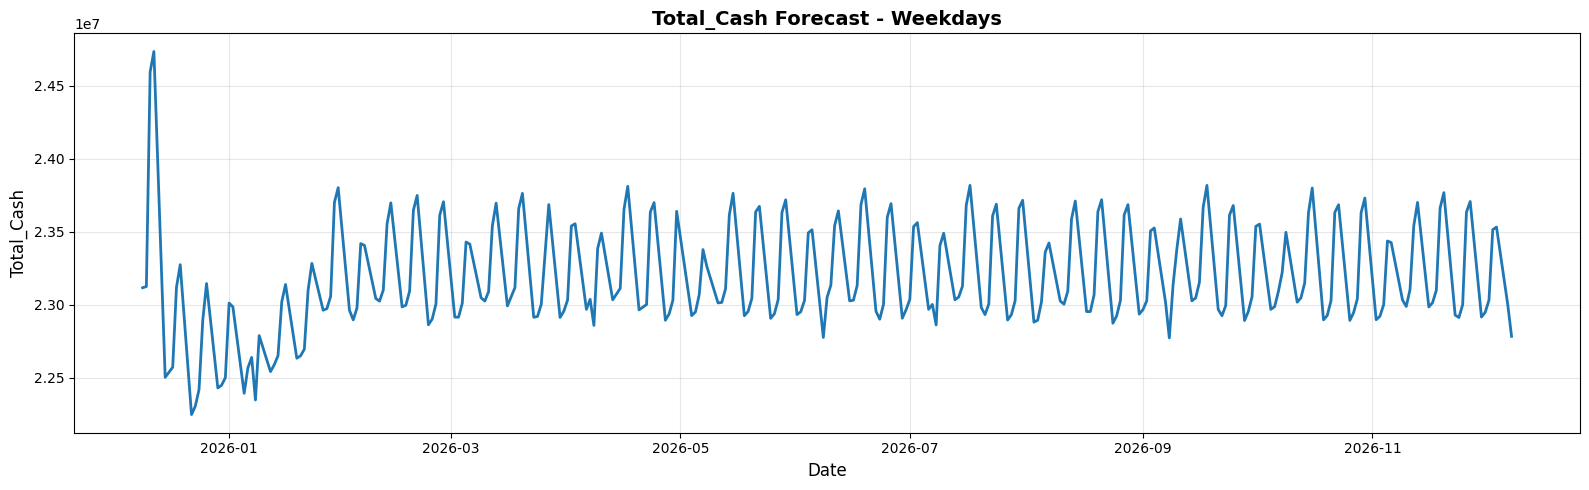

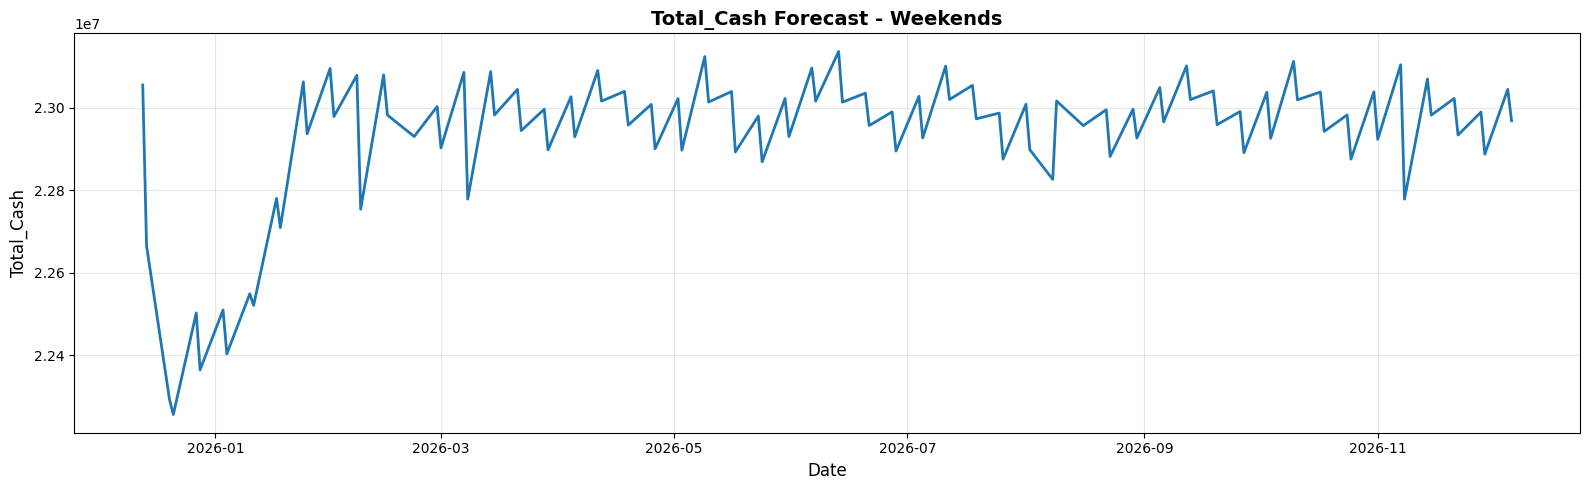

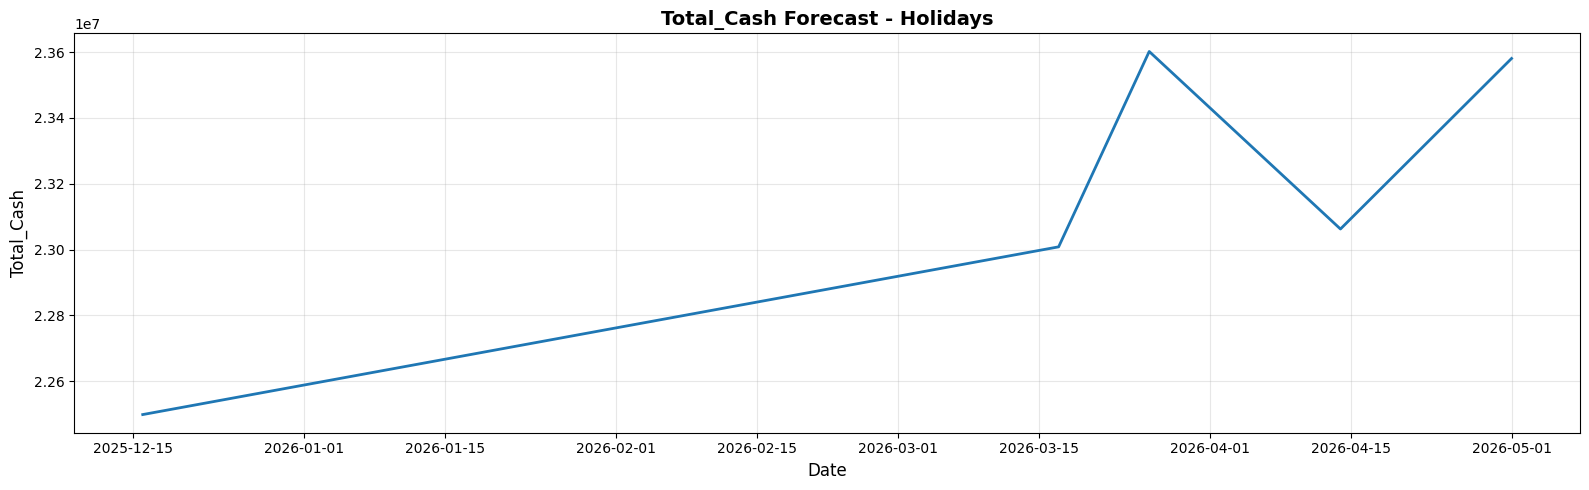

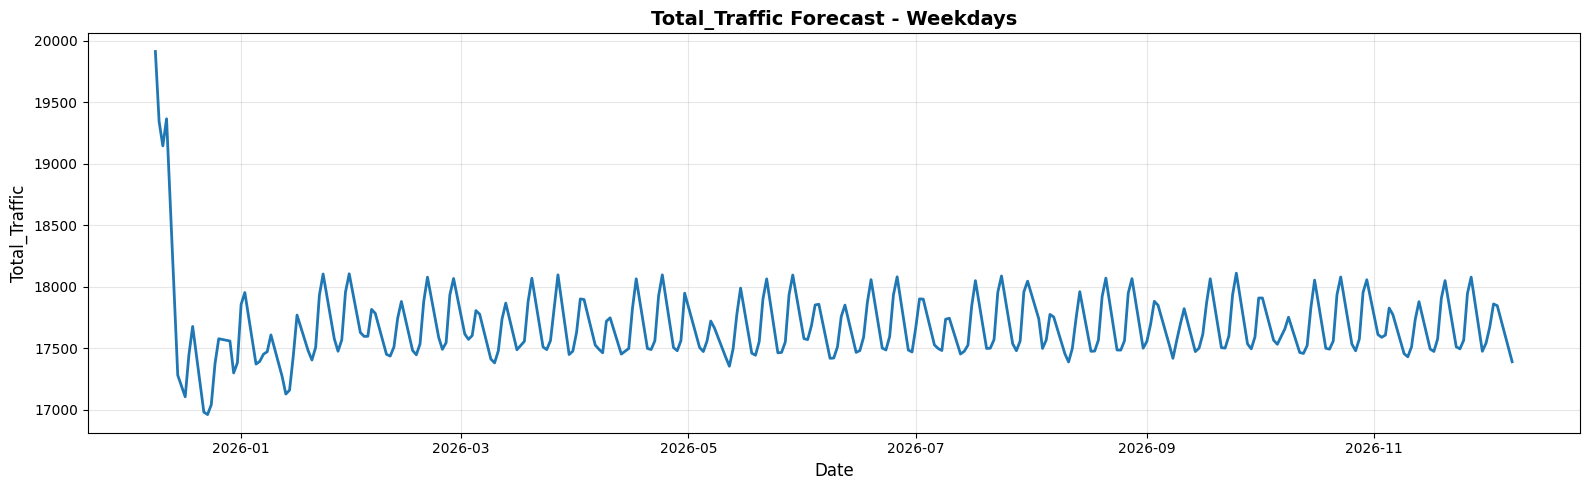

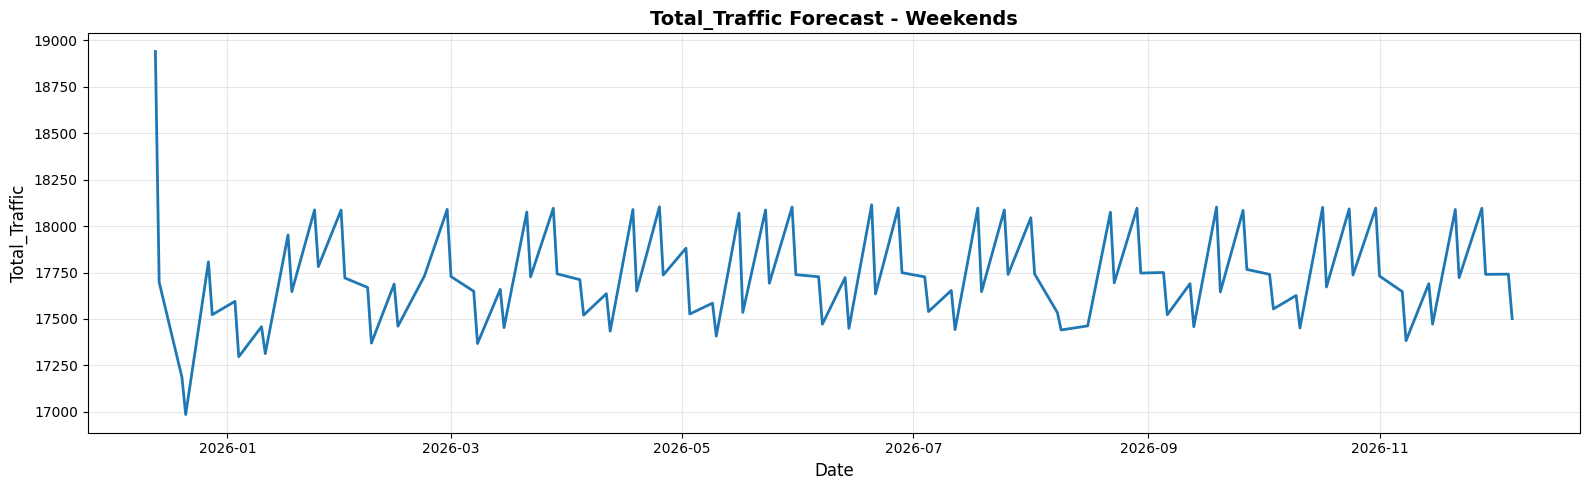

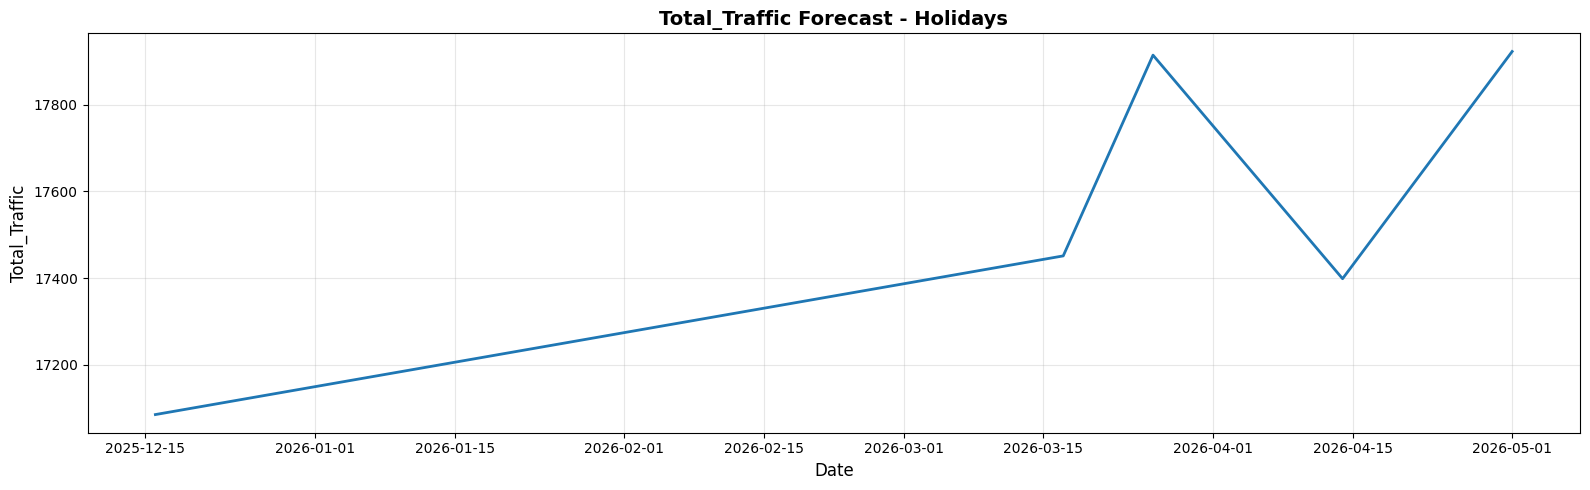

In [178]:
import matplotlib.pyplot as plt

df_plot = future_pred_df.copy()
df_plot['Date'] = df_plot.index
df_plot['DayOfWeek'] = df_plot.index.dayofweek
df_plot['isWeekend'] = df_plot['DayOfWeek'].isin([5,6])
df_plot['isHoliday'] = future_df['isHoliday'].values

categories = {
    'Weekdays': df_plot[~df_plot['isWeekend'] & ~df_plot['isHoliday']],
    'Weekends': df_plot[df_plot['isWeekend'] & ~df_plot['isHoliday']],
    'Holidays': df_plot[df_plot['isHoliday'] & ~df_plot['isWeekend']],
}

for col in target_cols:
    for cat_name, cat_df in categories.items():
        plt.figure(figsize=(16,5))
        plt.plot(cat_df['Date'], cat_df[col], color='tab:blue', linewidth=2)
        plt.title(f'{col} Forecast - {cat_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


In [179]:
df_table = future_pred_df.copy()
df_table['Date'] = df_table.index
df_table['isHoliday'] = future_df['isHoliday'].values

holiday_preds = df_table[df_table['isHoliday'] == 1]

cols = ['Date'] + target_cols
holiday_preds = holiday_preds[cols]

import IPython.display as display
display.display(holiday_preds.reset_index(drop=True))

Date  Traffic_Mawa  Traffic_Jajira     Cash_Mawa   Cash_Jajira  \
0 2025-12-16   8204.781974     9054.149398  1.112078e+07  1.121879e+07   
1 2026-02-21   8586.801519     9749.532574  1.128349e+07  1.162235e+07   
2 2026-03-17   8434.104575     9092.422356  1.132243e+07  1.158773e+07   
3 2026-03-26   9334.099988     9037.089443  1.192484e+07  1.164286e+07   
4 2026-04-14   8419.809703     9065.964640  1.133025e+07  1.158234e+07   
5 2026-05-01   9022.757848     9672.570780  1.185753e+07  1.163690e+07   
6 2026-08-15   8510.533162     9704.510718  1.128089e+07  1.161763e+07   

     Total_Cash  Total_Traffic  
0  2.249811e+07   17085.660572  
1  2.303459e+07   18096.167751  
2  2.300815e+07   17451.300042  
3  2.360223e+07   17913.926516  
4  2.306237e+07   17398.753918  
5  2.358095e+07   17922.344932  
6  2.306058e+07   17894.886066